# Variational auto-encoders

In this lab, you will look at variational auto-encoders.

In [1]:
# Numpy library provides useful numeric computation utilities
import numpy as np

# We import Pyplot for its plotting utilities
import matplotlib.pyplot as plt

# We import torch, torch.nn and torchvision, since these provide the neural 
# network and image processing utilities we will use
import torch
import torch.nn as nn
import torchvision

# We also import the functional module of torch.nn, since it has some useful 
# functions implemented in Pytorch
import torch.nn.functional as F

# torchvision.transforms is used to load images into adequate Pytorch tensors.
# It also provides some potentially useful utilities to transform images (more 
# on this later).
import torchvision.transforms as transforms

## Prepare the data
We will again use the FashionMNIST dataset, which you encountered in previous labs:

![<Image not loaded>](https://miro.medium.com/max/1400/1*RCXpLibVCgoRYckEd2kU8Q.png)

Recall that FashionMNIST consists of a dataset of 60,000 training images and 10,000 test images. Each example is a 28&times;28 grayscale image, associated with a label from 10 classes, corresponding to a piece of clothing:

| Label   |  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 
| ------- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Object  | T-shirt | Trousers | Pull-over | Dress | Coat | Sandal | Shirt | Sneaker | Bag | Boot |

We start by loading the dataset and then creating the associated dataloaders, which will be used to sample batches of images during training.

In [2]:
# The images, once loaded, are transformed in two ways: 
#  - They are turned to tensors
#  - They are normalized

# We construct a "transformator" to perform those two things.
transformator = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# We can now import the training and test data
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transformator)

valid_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transformator)

# We now create our dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=10000)

## VAE model

We define our VAE model by defining the encoder and decoder, separately, and then putting the two together. We start with the decoder.

In [3]:
class decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        # input.size: (b, latent_dim)
        # output.size: (b, output_dim)
        return self.layers(input)

... and now the encoder.

In [4]:
class encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        ''' input_dim is a list with the c x w x h of the input image.'''
        super().__init__()

        kernels = [5, 3]
        channels = [5, 10]
        pool = [2, 2]

        # Get dimensions right
        # - Output of conv layer 1
        conv1 = [channels[0], 
                 input_dim[1] - kernels[0] + 1, 
                 input_dim[2] - kernels[0] + 1]
        
        # - Output of max-pool layer 1
        maxp1 = [conv1[0], 
                 (conv1[1] - pool[0]) // pool[0] + 1, 
                 (conv1[2] - pool[0]) // pool[0] + 1]
        
        # - Output of conv layer 2
        conv2 = [channels[1], 
                 maxp1[1] - kernels[1] + 1, 
                 maxp1[2] - kernels[1] + 1]
        
        # - Output of max-pool layer 2
        maxp2 = [conv2[0],
                 (conv2[1] - pool[1]) // pool[1] + 1, 
                 (conv2[2] - pool[1]) // pool[1] + 1]

        # - Input to FC layer
        flat = maxp2[0] * maxp2[1] * maxp2[2]

        # Define convolutional encoder
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim[0], channels[0], kernel_size=kernels[0]),
            nn.MaxPool2d(pool[0]),
            nn.ReLU(),
            nn.Conv2d(channels[0],  channels[1], kernel_size=kernels[1]),
            nn.MaxPool2d(pool[1]),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(flat, hidden_dim),
            nn.ReLU(),
        )

        self.head_mu  = nn.Linear(hidden_dim, latent_dim)
        self.head_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, input):
        # input.size: (batch, c, w, h)
        
        h = self.layers(input)
        # h.size: (b, hidden_dim)

        mu = self.head_mu(h)
        # mu.size: (b, latent_dim)
        
        logvar = self.head_var(h)
        # logvar.size: (b, latent_dim)

        return mu, logvar

We can put everything together to build our VAE model.

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, output_dim):
        ''' both input_dim and output_dim are lists [c, w, h].'''
        super().__init__()

        self.output_dim = output_dim

        self.enc = encoder(input_dim, hidden_dim, latent_dim)
        self.dec = decoder(latent_dim, hidden_dim, np.prod(output_dim))

    def forward(self, input):
        # input.size: (b, c, w, h)
        mu_z, logvar_z = self.enc(input)
        # mu_z.size: (b, latent_dim)
        # logvar_z.size: (b, latent_dim)
        
        # Compute standard deviation
        sigma_z = torch.exp(logvar_z / 2)
        # sigma_z.size: (b, latent_dim)
        
        # Sample (0, 1) Gaussian tensor
        eps = torch.randn(mu_z.size())
        # eps.size: (b, latent_dim)

        # Compute latent variable (reparametrization trick)
        z = mu_z + eps * sigma_z
        # z.size: (b, latent_dim)

        # Run latent variable through decoder
        mu_x = self.dec(z)
        # mu_x.size: (b, output_dim)

        # We reshape mu_x to the size of an image
        mu_x = mu_x.view(-1, *output_dim)

        return mu_x, mu_z, logvar_z

In order to train our VAE, we need to compute the loss from the ELBO. The next function does precisely that. Recall that the ELBO loss is given by

$$L(w,\theta)=\log q_\theta(z\mid x)-\log_{\rm prior}(z)-\log p_w(x\mid z).$$

The last term is just the negative log likelihood of the image x generated from z. The first term is the KL divergence between $q_\theta$ and $p_{\rm prior}$. We compute each of the two terms separately. Note that:

* The negative log-likelihood of the image, $-\log p_w(x\mid z)$, corresponds to the mean squared error between $x$ and the mean of $p_w(\cdot\mid z)$ (up to a constant).
* The KL divergence between $q_\theta$ and the prior is simply

$$ KL(q_\theta, p_{\rm prior})=-\frac{1}{2}(\log\sigma_z^2-\mu_z^2-\sigma_z^2 + 1),$$

where $\mu_z$ and $\sigma_z$ are the mean and standard deviation of $q_\theta(\cdot\mid z)$. 

In [6]:
def elbo_loss(x, mu_x, mu_z, logvar_z):
    # The negative log-likelihood of x, up to a constant,
    # corresponds to the mean-squared error between x and mu_x
    nll = torch.sum(F.mse_loss(mu_x, x, reduction='none').view(x.shape[0], -1), dim=1) 
    # x.size: (b, c, w, h)
    # mu_x.size: (b, c, w, h)

    # The KLD between two Gaussians has a closed form, given by:
    # 
    # KLD(p1 || p2) = log(s2 / s1) - 0.5 * (1 - ((mu1 - mu2) ** 2 + s1 ** 2) / s2 ** 2)
    #
    # In our case, since mu2 = 0 and s2 = 1 (the prior), we get
    #
    # KLD(p1 || p2) = -log(s1) - 0.5 * (1 - mu1 ** 2 + s1 ** 2)
    # 
    # Finally, since 
    #   . log(s1) = 0.5 logvar_z
    #   . s1 ** 2 = logvar_z.exp()
    #   . mu1 = mu_z,
    kld = torch.sum(-0.5 * (logvar_z - mu_z ** 2 - logvar_z.exp() + 1), dim=1)
    # logvar_z.size: (b, latent_dim)
    # mu_z.size: (b, latent_dim)

    return torch.mean(nll + kld)

## Training and evaluation functions

Much like in the previous labs, we define training and evaluation functions to help us keep track of the performance of our model. We start with the evaluation function.

In [7]:
def evaluate(net, Xbatch):
  
    # Compute batch size
    batch_size = Xbatch.size(0)

    # We set the network to "evaluation mode".
    net.eval()

    # We compute the mean output image
    output, _, _ = net(Xbatch)

    # Compute mean squared error of mean image
    err = F.mse_loss(output, Xbatch).item()

    # We reset the network back to training mode
    net.train()
    
    return err

In [8]:
def train_network(net, optimizer, dataloader, num_epochs=20):
    
    # We initialize a list to track the loss during training.
    train_losses = []
    valid_losses = []

    for ep in range(num_epochs):
        print('\n- Training epoch: %i -' % ep)

        # We use auxiliary variables to keep track of the loss within an epoch
        running_loss = 0.
        dataset_size = 0

        for Xbatch, ybatch in dataloader:
            batch_size = Xbatch.size(0)
            dataset_size += batch_size
            
            # We zero-out the gradient
            optimizer.zero_grad()

            # Compute output
            mu_x, mu_z, logvar_z = net(Xbatch)

            # Get loss
            l = elbo_loss(Xbatch, mu_x, mu_z, logvar_z)

            # Compute gradient
            l.backward()
            
            # Perform optimization step
            optimizer.step()

            # Update total running loss. We account for the number of points 
            # in the batch
            running_loss += l.item() * batch_size
             
        train_losses += [running_loss / dataset_size]

        # Loss in the validation set
        val_x, val_y = next(iter(valid_loader))
        val_err = evaluate(net, val_x)

        valid_losses += [val_err]

        print(f'Training loss: {train_losses[-1]:.4f}')
        print(f'Validation loss: {valid_losses[-1]:.4f}')

    return net, train_losses, valid_losses

Let's train.

In [9]:
input_dim = [1, 28, 28]
latent_dim = 2 # Very small latent space
hidden_dim = 256
output_dim = input_dim

# We create our VAE model
vae = VAE(input_dim, latent_dim, hidden_dim, output_dim)

# We use stochastic gradient descent as the optimizer
adam = torch.optim.Adam(vae.parameters(), lr=0.005)

vae, train_loss, valid_loss = train_network(vae, adam, train_loader, num_epochs=20)


- Training epoch: 0 -
Training loss: 499.8859
Validation loss: 0.6191

- Training epoch: 1 -
Training loss: 490.0862
Validation loss: 0.6171

- Training epoch: 2 -
Training loss: 488.9825
Validation loss: 0.6152

- Training epoch: 3 -
Training loss: 488.3815
Validation loss: 0.6151

- Training epoch: 4 -
Training loss: 487.9547
Validation loss: 0.6149

- Training epoch: 5 -
Training loss: 487.6216
Validation loss: 0.6146

- Training epoch: 6 -
Training loss: 487.4003
Validation loss: 0.6140

- Training epoch: 7 -
Training loss: 487.3319
Validation loss: 0.6144

- Training epoch: 8 -
Training loss: 487.1754
Validation loss: 0.6141

- Training epoch: 9 -
Training loss: 486.9662
Validation loss: 0.6135

- Training epoch: 10 -
Training loss: 486.9155
Validation loss: 0.6131

- Training epoch: 11 -
Training loss: 486.8204
Validation loss: 0.6135

- Training epoch: 12 -
Training loss: 486.7316
Validation loss: 0.6127

- Training epoch: 13 -
Training loss: 486.5982
Validation loss: 0.6132

-

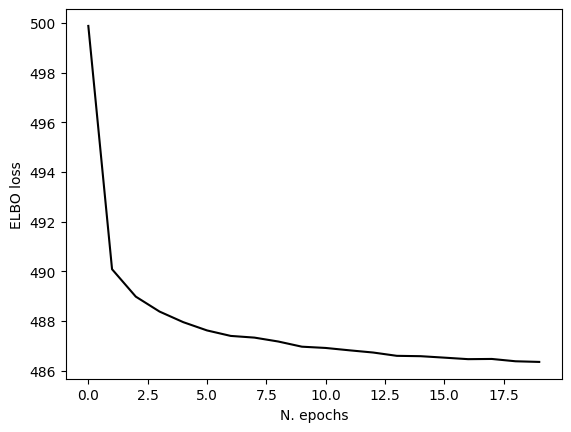

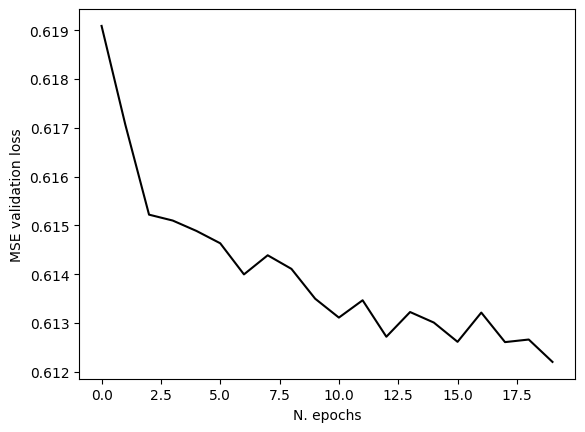

In [10]:
plt.figure()
plt.plot(train_loss, 'k-')
plt.xlabel('N. epochs')
plt.ylabel('ELBO loss')
plt.show()

plt.figure()
plt.plot(valid_loss, 'k-')
plt.xlabel('N. epochs')
plt.ylabel('MSE validation loss')
plt.show()

Let's observe some generated images.

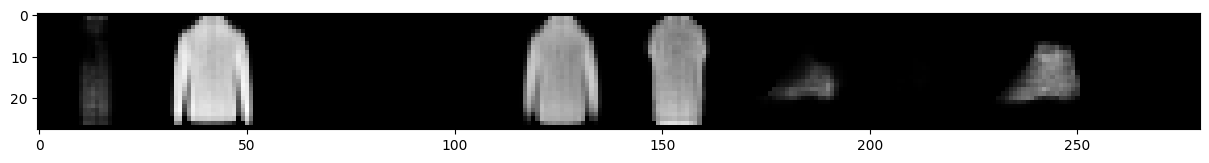

In [19]:
grid = []

for _ in range(10):
    z = torch.randn(1, 2)
    mu_x = vae.dec(z).reshape(28, 28).detach().numpy()
    grid += [mu_x]

grid = np.hstack(grid)

# To plot the sample, we create a grid
plt.figure(figsize=(15, 10))

# Plot the samples
plt.imshow(grid, cmap='gray')
plt.show()

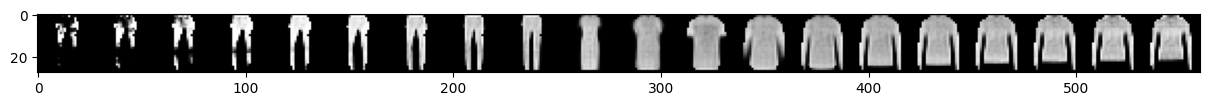

In [31]:
grid = []

n_steps = 20
ii=0
jj=2
for ii in torch.linspace(-4, 4, n_steps):
    dim1_change = ii
    dim2_change = jj
    z = torch.tensor(
        [[0, 0]]) + torch.tensor([[dim1_change, dim2_change]])
    mu_x = vae.dec(z).reshape(28, 28).detach().numpy()
    grid += [mu_x]

grid = np.hstack(grid)

# To plot the sample, we create a grid
plt.figure(figsize=(15, n_steps))

# Plot the samples
plt.imshow(grid, cmap='gray')
plt.show()

# Activities

1. Today we covered deep generative models, such as VAEs and GANs. GANs, in particular, have the ability to generate very realistic synthetic data. Identify one possible ethical challenge involved with this type of models, explaining your reasoning.

2. Why is discrimination bias a problem for deep learning technology? Support your argument with a possible real-world scenario.

3. One of the ethical challenges that was discussed today was related with _accessibility_, which we discussed in particular in the context of natural language processing. Can you identify another domain in which accessibility of deep learning technology (or lack thereof) can contribute to accentuate inequality or unfairness?